In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def draw_spectrogram(snd, title):
    sns.set() # Use seaborn's default style to make attractive graphs
    plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook
    plt.plot(snd.xs(), snd.values.T)
    plt.xlim([snd.xmin, snd.xmax])
    plt.xlabel("time [s]")
    plt.ylabel("amplitude")
    plt.title(title)
    plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

def save_to_wav(snd, filename):
    if ".wav" not in filename:
        filename = filename + ".wav"
    snd.save(filename, "WAV")

import math
def convert_f0_to_semitone(f0):
    res = []
    for freq in f0:
        if freq != 0:
            res.append(round(12*math.log((freq/440),2)+69))
        else:
            res.append(0)
    return res

import pandas as pd
def extract_ori_pitch_to_csv(file):
    snd = parselmouth.Sound(file)

    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']

    time = []
    f0 = []

    for i in range(len(pitch_values)):
        # if pitch_values[i]!=0:
        f0.append(pitch_values[i].round(decimals=3))
        time.append(pitch.xs()[i].round(decimals=3))

    file_csv = file.replace(".wav","-parselmouth.csv")

    semitone = convert_f0_to_semitone(f0)

    pd.DataFrame({'time':time, 'semitone':semitone, 'f0':f0}).to_csv(file_csv, index=False)

import parselmouth
def remove_noise_with_spectral_subtraction(snd):
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']

    final_unvoiced_length = 0
    final_unvoiced_start_time = 0.0
    final_unvoiced_end_time = 0.0
    found_unvoiced = False
    
    for i in range(len(pitch_values)-1):
        temp_unvoiced_length = 0
        temp_unvoiced_start_time = pitch.xs()[i].round(decimals=3)

        while pitch_values[i] == 0.0 and i < len(pitch_values)-1:
            temp_unvoiced_length += 1
            i += 1
        
        temp_unvoiced_end_time = pitch.xs()[i].round(decimals=3)

        bandwidth = temp_unvoiced_end_time - temp_unvoiced_start_time
        # batas minimal bandwidth praat = 0.0625 (dalam detik)

        if temp_unvoiced_length > final_unvoiced_length:
            if temp_unvoiced_start_time <= 0.1 and bandwidth > 0.5 :
                final_unvoiced_length = temp_unvoiced_length
                final_unvoiced_start_time = temp_unvoiced_start_time
                final_unvoiced_end_time = temp_unvoiced_end_time
                found_unvoiced = True
                break
            elif found_unvoiced == False:
                final_unvoiced_length = temp_unvoiced_length
                final_unvoiced_start_time = temp_unvoiced_start_time
                final_unvoiced_end_time = temp_unvoiced_end_time

    if final_unvoiced_length!=0:
        # snd_unvoiced = snd.extract_part(from_time = final_unvoiced_start_time, to_time = final_unvoiced_end_time, 
        # preserve_times=True)
        
        snd_noise_removed = parselmouth.praat.call(snd, "Remove noise", final_unvoiced_start_time, 
        final_unvoiced_end_time, 0.025, 80.0, 10000.0, 40.0, "Spectral subtraction")

        parselmouth.Vector.scale_peak(snd_noise_removed)

        # return parselmouth object
        return snd_noise_removed
    else:
        print("no unvoiced segment found for", filename)
        return snd

In [6]:
# code taken from https://dspillustrations.com/pages/posts/misc/fourier-series-and-harmonic-approximation.html
def fourierSeries(period, N):
    """Calculate the Fourier series coefficients up to the Nth harmonic"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

# code taken from https://dspillustrations.com/pages/posts/misc/fourier-series-and-harmonic-approximation.html
def reconstruct(P, anbn):
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result += a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

import numpy as np
def compute_FSD(data):
    # assume sample rate = 64000
    # with n_frame = 640, each frame will contain 100 samples
    # with n_harmonics = 10, each frame will reduce from 100 samples to 10 harmonics
    n_frame = 640
    n_harmonics = 10

    # Framing
    data_split = np.array_split(data,n_frame)

    new_data = np.array([])
    
    for frame in data_split:
        # Fourier series Expansion with N order
        F = fourierSeries(frame, n_harmonics)

        # Frame reconstrucon
        frame_i = reconstruct(len(frame), F[:n_harmonics,:])

        # Signal reconstrucon
        new_data = np.concatenate((new_data, frame_i), axis=None)

    return new_data

import parselmouth
def remove_noise_with_FSD(filename):
    snd = parselmouth.Sound(filename)
    data = snd.values[0]
    samplerate = snd.sampling_frequency

    clean_data = compute_FSD(data)
    clean_snd = parselmouth.Sound(values=clean_data,sampling_frequency=samplerate)

    return clean_snd

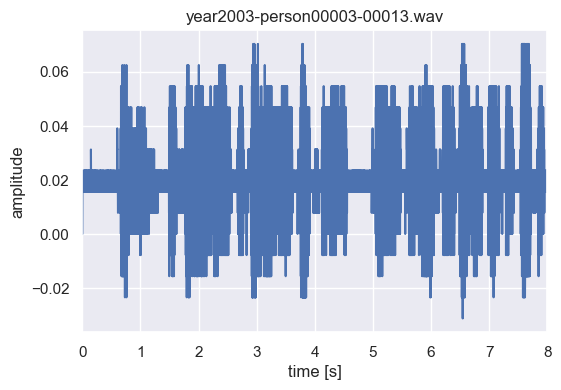

In [3]:
filename = 'year2003-person00003-00013.wav'

import parselmouth

snd = parselmouth.Sound(filename)
draw_spectrogram(snd, filename)

Fourier series: 0.902


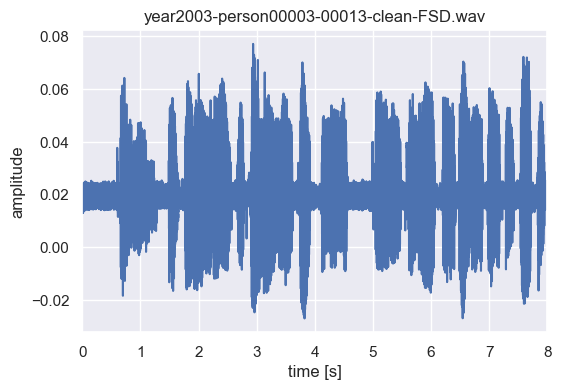

Spectral subtraction: 0.121


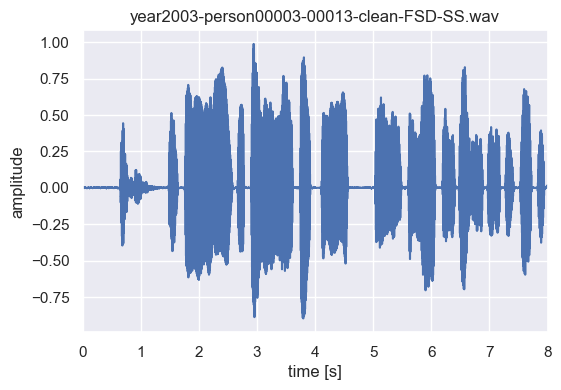

In [9]:
filename = 'year2003-person00003-00013.wav'

import parselmouth
import time

start_time = time.time()
clean_snd = remove_noise_with_FSD(filename)
duration = round(time.time() - start_time, 3)
print("Fourier series:",duration)

new_filename = filename.replace(".wav","-clean-FSD.wav")
draw_spectrogram(clean_snd, new_filename)
save_to_wav(clean_snd,new_filename)

start_time = time.time()
clean_snd = remove_noise_with_spectral_subtraction(clean_snd)
duration = round(time.time() - start_time, 3)
print("Spectral subtraction:",duration)

new_filename = new_filename.replace(".wav","-SS.wav")
draw_spectrogram(clean_snd, new_filename)
save_to_wav(clean_snd,new_filename)

In [ ]:
# detect unvoiced with parselmouth
# to be used in spectral subtraction as noisy sample

filename = 'year2003-person00003-00013.wav'
# filename = 'year2003-person00001-00013.wav'

import parselmouth

snd = parselmouth.Sound(filename)
draw_spectrogram(snd,"original")

clean_object = remove_noise_with_FSD(filename)
# save_to_wav(clean_object,filename.replace(".wav","")+"-clean.wav")
draw_spectrogram(clean_object,"clean-scaled")





# clean_object = remove_noise_with_spectral_subtraction(filename)
# save_to_wav(clean_object,filename.replace(".wav","")+"-clean.wav")
# draw_spectrogram(clean_object,"clean-scaled")